
* https://esperr.github.io/pubmed-by-year/?q1=LBD%20NOT%20(review[Publication%20Type])&q2=LBD&q3=LBD%20AND%20(review[Publication%20Type])
CSV download link example: has the actual data in it's url.. 

* https://esperr.github.io/pubmed-by-year/?q1=(PINK1)%20NOT%20(review[Publication%20Type])&q2=(ncRNA)%20AND%20(review[Publication%20Type])&q3=(ncRNA)%20NOT%20(review[Publication%20Type])&q4=(PINK1)%20AND%20(review[Publication%20Type])&q5=(microRNA,miRNA)%20AND%20(review[Publication%20Type])&q6=(microRNA,miRNA)%20NOT%20(review[Publication%20Type])&startyear=1980&endyear=2020#!

* https://esperr.github.io/pubmed-by-year/?q1=(sleep)%20AND%20(review[Publication%20Type])&q2=(sleep)%20NOT%20(review[Publication%20Type])&q3=antibiotic%20AND%20(review[Publication%20Type])&q4=antibiotic%20NOT%20(review[Publication%20Type])&q5=antibiotic%20NOT%20(review[Publication%20Type])&q6=antibiotic%20resistant&startyear=1945


Another (formatting broken):
* esperr.github.io/pubmed-by-year/?q1=(ncRNA) AND (review[Publication Type])&q2=(PINK1) AND (review[Publication Type])&q3=(ncRNA) NOT (review[Publication Type])&q4=(PINK1) NOT (review[Publication Type])&q5=(microRNA,miRNA) AND (review[Publication Type])&q6=(microRNA,miRNA) NOT (review[Publication Type])&startyear=1980&endyear=2020


--------------------
* **MeSH** headings [MH] - https://www.nlm.nih.gov/bsd/disted/meshtutorial/searchingpubmedusingmeshtags/index.html
    MeSH headings can be qualified using two search field tags:

                            [mh]     to search a MeSH heading
                            [majr]   to search a MeSH heading that is a major topic of an article

    Examples:

    eye [mh]
    eye [majr]
    
    "Psychiatry/ethics"[MAJR]
    
    * https://pubmed.ncbi.nlm.nih.gov/?term=%22Amino+Acids%2C+Peptides%2C+and+Proteins%22%5BMAJR%5D - `"Amino Acids, Peptides, and Proteins"[MAJR]`
    
* List of mesh major subheadings/high level:
    * https://www.nlm.nih.gov/mesh/subhierarchy.html
    * https://meshb-prev.nlm.nih.gov/treeView
    
* Quick DL list of MEsh terms TRee easily: https://raw.githubusercontent.com/dhimmel/mesh/gh-pages/data/tree-numbers.tsv
* Major topic: `[MeSH Major Topic]`


* https://esperr.github.io/pubmed-by-year/?q1=Amino%20Acids,%20Peptides,%20and%20Proteins[MAJR]&q2=Amino%20Acids,%20Peptides,%20and%20Proteins[mesh]
* Topic vs major topic "decorrolates" after a certain date.. 
-------------------------------

*Google NGrams
* https://books.google.com/ngrams/graph?content=Albert+Einstein%2CSherlock+Holmes%2CFrankenstein&year_start=1930&year_end=2019&corpus=26&smoothing=3

* Ngrams api/packages:
    * https://stackoverflow.com/questions/67753096/how-i-get-the-occurrence-of-a-sentence-with-google-ngram-viewer-and-python
    * https://jameshfisher.com/2018/11/25/google-ngram-api/
    * https://gitlab.com/cpbl/google-ngrams

-----------------------------------
Could add:
* Mesh terms TS
* Mesh categories/distrib per search term - https://esperr.github.io/mesh-cat-graph/ - not downloadable/machine readable format figure


* CRISPR - example of many reviews, early on . 
* Time to/from peak of papers vs reviews starting ? (of reviews)


MIN 3 years of papers

~ 3 classes. 


Consider taking from ~ 1980s+ data (better annotation?)

* Human genetics, plant, animal husbandry genetics - one method appearing decades before in each field (under another name). 
    * word2vec between domains?  
    * qtl, eqtl, 


In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn

import functools
import logging
import json
from bs4 import BeautifulSoup
import urllib
import re
from sklearn.model_selection import cross_val_predict ## time split? 
from sklearn.linear_model import LinearRegression
import urllib.request
# import time
# localtime = time.asctime( time.localtime(time.time()) )
# import urllib2
import csv
import sys
from sklearn.metrics import roc_auc_score, classification_report

pd.options.mode.use_inf_as_na = True

In [2]:
def get_pubmed_year_terms_url(terms_list:[],get_reviews=False,
                              get_mesh=False,get_mesh_major=True,max_len=60):
    """
    Generate URLs from a given list of terms for downloading
    (manually) from https://esperr.github.io/pubmed-by-year
    
    Max length supported seems to be maybe 77? I set to 60 for safety
    """
    q = 1
    url = "https://esperr.github.io/pubmed-by-year/?"
    suffix=""
    if get_reviews:
        suffix+="%20AND%20(review[Publication%20Type])"
    if get_mesh:
        suffix+="[mh]"   
        if get_mesh_major:
            suffix="[majr]" # overwrites just mesh
        
    terms_list = list(set(terms_list)) # deduplicate
    ## handle long cases - recursion
    while len(terms_list)>max_len:
        get_pubmed_year_terms_url(terms_list[0:max_len],get_reviews,
                              get_mesh,get_mesh_major,max_len)
        terms_list = terms_list[max_len:]
        
    for index, term in enumerate(terms_list):
        term = term.replace(" ","%20") # for spaces
        url = url+f"q{q}={term}"+suffix
        q +=1
        if index<len(terms_list)-1: ## +1? 0 index?
            url = url+"&"

    print(url)
    print()

In [3]:
clf = LinearRegression()

#### MESH high level terms
* example: `https://esperr.github.io/pubmed-by-year/?q1=Health%20Care%20Facilities,%20Manpower,%20and%20Services[Mesh]` = "Health Care Facilities, Manpower, and Services[Mesh"]

* list: https://www.nlm.nih.gov/mesh/subhierarchy.html
*  16 top level cats: https://esperr.github.io/mesh-cat-graph/
    * https://www.nlm.nih.gov/bsd/disted/meshtutorial/meshtreestructures/index.html
* Could add # terms as major topic, vs non major topic (for some cases, there is a clear change/discontinuity!) ; e.g. `Amino Acids, Peptides, and Proteins	` : https://esperr.github.io/pubmed-by-year/?q1=Amino%20Acids,%20Peptides,%20and%20Proteins[mh]&q2=Amino%20Acids,%20Peptides,%20and%20Proteins[majr]


* https://www.nlm.nih.gov/bsd/disted/meshtutorial/searchingpubmedusingmeshtags/index.html
    ```
    [mh]     to search a MeSH heading
    [majr]   to search a MeSH heading that is a major topic of an article
    ```

In [4]:
### what about 16 top level cats? https://esperr.github.io/mesh-cat-graph/
mesh_cat = pd.read_csv("https://raw.githubusercontent.com/dhimmel/mesh/gh-pages/data/tree-numbers.tsv",sep="\t")
# mesh_cat = mesh_cat["mesh_tree_number"].str.split(".",expand=True)[0].drop_duplicates() ## 117 terms! a lot at the second level
mesh_cat = mesh_cat.loc[mesh_cat["mesh_tree_number"].str.len()<4]
## warning, unsuited, as pubmed by year needs name, not category term.

## D03[MeSH Major Topic] -> no results 
### should we do something about commas, etc'? Drop or clean? 

In [5]:
# mesh_cat.loc[mesh_cat["mesh_tree_number"].str.contains("[a-j]",case=False,regex=True)]

In [6]:
# mesh_cat["mesh_tree_number"].str.split("[A-Z]",regex=True,expand=True)[1].astype(int)
# mesh_cat["mesh_tree_number"].str.extract("([A-Za-z])(d+)",expand=True)

mesh_cat["num"] = mesh_cat["mesh_tree_number"].str.replace("[A-Z]","").astype(int)

mesh_cat.sort_values(["num"])

/var/folders/hl/bb0z87yd5pzfcp81jc8662kr0000gn/T/ipykernel_49593/1184913195.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  mesh_cat["num"] = mesh_cat["mesh_tree_number"].str.replace("[A-Z]","").astype(int)


,mesh_id,mesh_name,mesh_tree_number,num
25542,D013676,"Technology, Industry, and Agriculture",J01,1
10702,D005842,Geographic Locations,Z01,1
7216,D003933,Diagnosis,E01,1
47609,D052181,Publication Components,V01,1
12507,D006809,Humanities,K01,1
...,...,...,...,...
3044,D001697,Biomedical and Dental Materials,D25,25
55430,D064419,Chemically-Induced Disorders,C25,25
7937,D004364,Pharmaceutical Preparations,D26,26
27987,D014947,Wounds and Injuries,C26,26


### Terms list
* For each term - also +- review type (as secondary)

* note that e.g. "super resolution microscopy" has 2 cases of appearing in literature decades before it really did (false positives) - we'll want to filter for multiple occurences in dates as start point

Get preds on test set , e.g. CRISPR - look at peaks/prediction

* pcr,

* cases of decoupling? like AA

Debias by year (linear)


Patents (and crispr?)  .  e.g. # pred patents


* mesh - some terms split incorrectly ("hereditary" "and neonatal"

In [7]:
TERMS_LIST = list(set([
    "miRNA","prion","rnase","ncRNA","lncRNA","PCR","mass spectrometry",
    "ancient dna", "carbon dating", ## ancient dna - methods changed over time, C14.. 
    "sleep","coral","SNP","GWAS",
    "neural networks","artificial neural networks","machine learning","genetic algorithm",
    "antibiotic","antibiotic resistance","viral therapy","gene therapy",
    "microglia","junk dna",
    "eugenics","genetic engineering","vitamin D","vitamin C","race","ethnic differences",
    "influenza", "archaea","stem cells", "vaccine","Epidemiology",
    "Synthetic Biology","epigenetics","perceptron","eugenics","lithium","lipid",
    "Mononucleosis","epstein-barr","multiple sclerosis","autoimmune",
    "ribosome","ribozyme",
    "zebra fish","mouse","rnai","CRISPR","DNA array","RNA","NGS","single cell",
    "illumina","nanopore","BRCA1","BRCA2","cholesterol", "soy milk",
    "cumin","biosimilar","homeopathy","natural medicine","single cell","FACS",
    "Drug repurposing","LSD","cannabis","cannabidiol","MRI","fMRI","EEG","BLAST","HMM", ## profile-profile, homology,   
        "connectome","metabolome","metagenomics",
    "autism", "savant", "autoimmune" , "inflammatory",
    ### https://en.wikipedia.org/wiki/Neurotransmitter
    "glutamate", "GABA", "acetylcholine", "glycine" , "serotonin", "epinephrine", "Norepinephrine",
    "dopamine", "substance P", "opioids", "cocaine", "Histamine", "neuropeptide", "neutrotransmitter",
    ## some brain regions: + https://en.wikipedia.org/wiki/List_of_regions_in_the_human_brain
    "amygdala", "hippocampus", "neocortex", "basal ganglia", "lateral ventricles",
    "thalamus", "hypothalamus",
    "subthalamus", "pituitary gland","pineal gland" ,"cerebellum", "Medulla oblongata",
    "paleocortex" , "neocortex", "Brodmann area", "Prefrontal cortex", "Orbitofrontal cortex",
    "Dorsolateral prefrontal cortex", "somatosensory cortex", "Insular cortex", "Cingulate cortex",
    ### combine cannabis, canabidiol =  marijuana .  lsd.  
    ## psychiatric drugs, treatment 
]))
### GO subcellular organellas list ; brain regions
### drugs - painkillers, opioids, 
### list of tissues (GTX) = thyroid, skin, etc' 
### medical procedures?? 

print(len(TERMS_LIST), "# terms")
# TERMS_LIST

113 # terms


In [8]:
list(mesh_cat["mesh_name"])

['Amino Acids, Peptides, and Proteins',
 'Anesthesia and Analgesia',
 'Animal Diseases',
 'Animal Structures',
 'Archaea',
 'Bacteria',
 'Bacterial Infections and Mycoses',
 'Behavior and Behavior Mechanisms',
 'Mental Disorders',
 'Biological Factors',
 'Biological Phenomena',
 'Biomedical and Dental Materials',
 'Body Regions',
 'Carbohydrates',
 'Cardiovascular Diseases',
 'Cardiovascular System',
 'Cell Physiological Phenomena',
 'Cells',
 'Circulatory and Respiratory Physiological Phenomena',
 'Dentistry',
 'Diagnosis',
 'Digestive System',
 'Digestive System Diseases',
 'Behavioral Disciplines and Activities',
 'Pharmaceutical Preparations',
 'Health Care Economics and Organizations',
 'Education',
 'Embryonic Structures',
 'Endocrine System Diseases',
 'Endocrine System',
 'Environment and Public Health',
 'Equipment and Supplies',
 'Eye Diseases',
 'Health Care Facilities, Manpower, and Services',
 'Female Urogenital Diseases and Pregnancy Complications',
 'Fluids and Secretion

#### get total Medline papers/citations per year
* MEDLINE - not all papers, only mesh containing, but a decent proxy.
* "MEDLINE consists of completed citations indexed with MeSH"
* pd.read_html("https://www.nlm.nih.gov/bsd/medline_cit_counts_yr_pub.html")

In [8]:
df_medline = pd.read_html("https://www.nlm.nih.gov/bsd/medline_cit_counts_yr_pub.html")[0].drop(columns="# Citations Published in US")
print(df_medline.columns)
# df_medline

df_medline['Year of Publication'] = df_medline['Year of Publication'].str.replace("*","",regex=False)
df_medline['%s Citations Published in US'] = df_medline['%s Citations Published in US'].str.replace("%","",regex=False)
df_medline['Year of Publication'] = pd.to_numeric(df_medline['Year of Publication'],errors="coerce")
df_medline.dropna(subset=['Year of Publication'],axis=0,inplace=True)
df_medline['Year of Publication'] = df_medline['Year of Publication'].astype(int).astype("str")
df_medline.columns = ["Year","Total Medline Cites","% US Citations"]
df_medline['% US Citations'] = pd.to_numeric(df_medline['% US Citations'],errors="coerce")
df_medline["Year"] = pd.to_datetime(df_medline["Year"])

df_medline.to_csv("medline_total.csv.gz",index=False,compression="gzip")
df_medline

Index(['Year of Publication', 'Total # Citations',
       '%s Citations Published in US'],
      dtype='object')


,Year,Total Medline Cites,% US Citations
0,2020-01-01,362528,38.0
1,2019-01-01,898145,39.0
2,2018-01-01,866977,40.0
3,2017-01-01,848776,41.0
4,2016-01-01,862829,41.0
...,...,...,...
69,1951-01-01,102578,NaN
70,1950-01-01,84099,NaN
71,1949-01-01,60931,NaN
72,1948-01-01,68711,NaN


https://esperr.github.io/pubmed-by-year/?q1=(sleep)%20AND%20(review[Publication%20Type])&q2=(sleep)%20NOT%20(review[Publication%20Type])&q3=antibiotic%20AND%20(review[Publication%20Type])&q4=antibiotic%20NOT%20(review[Publication%20Type])&q5=antibiotic%20NOT%20(review[Publication%20Type])&q6=antibiotic%20resistant&startyear=1945


https://esperr.github.io/pubmed-by-year/?q1=miRNA&q2=ncRNA&q3=miRNA%20AND%20(review[Publication%20Type])

In [9]:
# get_pubmed_year_terms_url(terms_list=['epigenetics',
#  'antibiotic resistance',
#  'sleep',
#  'vitamin D',
#  'neocortex',
#  'metabolome',
#  'pituitary gland'])
get_pubmed_year_terms_url(terms_list=TERMS_LIST,get_reviews=False)
## save as - a_111_terms_PubMed by Year.csv , b_111_terms_PubMed by Year.csv

https://esperr.github.io/pubmed-by-year/?q1=perceptron&q2=zebra%20fish&q3=acetylcholine&q4=hypothalamus&q5=Cingulate%20cortex&q6=fMRI&q7=rnase&q8=opioids&q9=ribosome&q10=cannabis&q11=thalamus&q12=Synthetic%20Biology&q13=epigenetics&q14=vaccine&q15=vitamin%20C&q16=neutrotransmitter&q17=Norepinephrine&q18=archaea&q19=Dorsolateral%20prefrontal%20cortex&q20=savant&q21=BRCA1&q22=ethnic%20differences&q23=pineal%20gland&q24=artificial%20neural%20networks&q25=GWAS&q26=cumin&q27=mouse&q28=Drug%20repurposing&q29=amygdala&q30=single%20cell&q31=influenza&q32=biosimilar&q33=homeopathy&q34=genetic%20algorithm&q35=CRISPR&q36=ancient%20dna&q37=dopamine&q38=SNP&q39=cholesterol&q40=PCR&q41=Orbitofrontal%20cortex&q42=BLAST&q43=multiple%20sclerosis&q44=Insular%20cortex&q45=vitamin%20D&q46=Histamine&q47=natural%20medicine&q48=FACS&q49=GABA&q50=stem%20cells&q51=microglia&q52=connectome&q53=epinephrine&q54=DNA%20array&q55=prion&q56=race&q57=basal%20ganglia&q58=somatosensory%20cortex&q59=antibiotic&q60=antibi

In [10]:
get_pubmed_year_terms_url(terms_list=TERMS_LIST,get_reviews=True)

https://esperr.github.io/pubmed-by-year/?q1=perceptron%20AND%20(review[Publication%20Type])&q2=zebra%20fish%20AND%20(review[Publication%20Type])&q3=acetylcholine%20AND%20(review[Publication%20Type])&q4=hypothalamus%20AND%20(review[Publication%20Type])&q5=Cingulate%20cortex%20AND%20(review[Publication%20Type])&q6=fMRI%20AND%20(review[Publication%20Type])&q7=rnase%20AND%20(review[Publication%20Type])&q8=opioids%20AND%20(review[Publication%20Type])&q9=ribosome%20AND%20(review[Publication%20Type])&q10=cannabis%20AND%20(review[Publication%20Type])&q11=thalamus%20AND%20(review[Publication%20Type])&q12=Synthetic%20Biology%20AND%20(review[Publication%20Type])&q13=epigenetics%20AND%20(review[Publication%20Type])&q14=vaccine%20AND%20(review[Publication%20Type])&q15=vitamin%20C%20AND%20(review[Publication%20Type])&q16=neutrotransmitter%20AND%20(review[Publication%20Type])&q17=Norepinephrine%20AND%20(review[Publication%20Type])&q18=archaea%20AND%20(review[Publication%20Type])&q19=Dorsolateral%20pr

In [11]:
### get MESH terms - global context. ~113 terms
get_pubmed_year_terms_url(terms_list=list(mesh_cat["mesh_name"]),get_reviews=False,get_mesh=True,
    get_mesh_major=True)

https://esperr.github.io/pubmed-by-year/?q1=Endocrine%20System%20Diseases[majr]&q2=Organic%20Chemicals[majr]&q3=Parasitic%20Diseases[majr]&q4=Food%20and%20Beverages[majr]&q5=Musculoskeletal%20Diseases[majr]&q6=Immune%20System%20Phenomena[majr]&q7=Hemic%20and%20Lymphatic%20Diseases[majr]&q8=Behavior%20and%20Behavior%20Mechanisms[majr]&q9=Disorders%20of%20Environmental%20Origin[majr]&q10=Organism%20Forms[majr]&q11=Polycyclic%20Compounds[majr]&q12=Integumentary%20System%20Physiological%20Phenomena[majr]&q13=Cardiovascular%20Diseases[majr]&q14=Bacterial%20Infections%20and%20Mycoses[majr]&q15=Stomatognathic%20System[majr]&q16=Skin%20and%20Connective%20Tissue%20Diseases[majr]&q17=Eukaryota[majr]&q18=Health%20Care%20Economics%20and%20Organizations[majr]&q19=Digestive%20System[majr]&q20=Information%20Science[majr]&q21=Inorganic%20Chemicals[majr]&q22=Lipids[majr]&q23=Natural%20Science%20Disciplines[majr]&q24=Biological%20Factors[majr]&q25=Hemic%20and%20Immune%20Systems[majr]&q26=Nucleic%20Acids

In [12]:
# ## worked, before adding in alts
# q = 1
# urlstem = "https://esperr.github.io/pubmed-by-year/?"
# url = urlstem
# for index, term in enumerate(TERMS_LIST):
#     term = term.replace(" ","%20") # for spaces
#     url = url+f"q{q}={term}"
#     q +=1
#     if index<len(TERMS_LIST)-1: ## +1? 0 index?
#         url = url+"&"

# print(url)        

In [13]:
# ## + +- review
# q = 1
# urlstem = "https://esperr.github.io/pubmed-by-year/?"
# url = urlstem
# for index, term in enumerate(TERMS_LIST):
#     term = term.replace(" ","%20") # for spaces
#     url = url+f"q{q}={term}"+"%20AND%20(review[Publication%20Type])"
#     q +=1
#     if index<len(TERMS_LIST)-1: ## +1? 0 index?
#         url = url+"&"

# print(url)        

#### attempted pubmed scraping of timeine table
* e.g.: https://pubmed.ncbi.nlm.nih.gov/?term=micro%20RNA&timeline=expanded

### all mesh terms

In [14]:
df_mesh = pd.read_csv("a_mesh_majr.csv",parse_dates=["Year"]).set_index("Year")
df_mesh = df_mesh.join(pd.read_csv("b_mesh_majr.csv",parse_dates=["Year"]).set_index("Year"))
print(df_mesh.shape)
assert df_mesh.shape[1]>= len(list(mesh_cat["mesh_name"]))
df_mesh.dropna(how="all",axis=1,inplace=True) ## some missing
print(len(mesh_cat["mesh_name"]) - df_mesh.shape[1],"cols missing") ## wrong answer? 
df_mesh

(77, 129)
4 cols missing


,Embryonic Structures[majr],Digestive System[majr],Bacterial Structures[majr],Information Science[majr],Human Activities[majr],Support of Research[majr],Stomatognathic System[majr],Biological Factors[majr],Heterocyclic Compounds[majr],Cardiovascular Diseases[majr],...,Access,and Evaluation[majr],Reproductive and Urinary Physiological Phenomena[majr],Humanities[majr],Tissues[majr],Genetic Phenomena[majr],Viral Structures[majr],Musculoskeletal System[majr],Plant Structures[majr],Cell Physiological Phenomena[majr]
Year,,,,,,,,,,,,,,,,,,,,,
1945-01-01,443.621118,3982.840150,4.874957,823.867791,589.869839,4.874957,1579.486179,2296.104909,4445.961098,2846.975089,...,843.367621,887.242237,48.749573,3534.344074,5284.453761,770.243260,1569.736265,2681.226539,4.874957,1496.611905
1946-01-01,684.194912,4867.240228,1.854187,1412.890306,780.612623,7.416747,2516.131425,2677.445672,6200.400504,3923.459171,...,1055.032263,991.989913,81.584217,3361.640584,6767.781651,1420.307053,2321.441816,3686.123266,16.687681,1857.895127
1947-01-01,694.850115,4928.516526,0.000000,1165.257494,699.461952,4.611837,2332.052267,2395.080707,5913.912375,4061.491161,...,974.634896,963.873943,78.401230,2682.551883,6308.993082,1346.656418,2227.517294,2536.510377,21.521906,1938.508839
1948-01-01,583.687833,5141.540766,0.000000,1018.980454,586.514408,0.000000,2151.023927,2361.603799,5549.980921,4426.417174,...,946.902780,1023.220317,137.088910,2196.249134,6221.292593,1376.542250,2121.344885,1883.912546,21.199316,1854.233503
1949-01-01,689.205106,6121.669373,0.000000,1087.129532,651.004361,12.733582,2336.612231,2588.100468,5316.270334,4709.833508,...,1045.745392,982.077484,148.027887,2215.643205,6449.559100,1150.797441,2306.369974,1905.262153,19.100372,2013.497597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-01,450.322547,1367.006736,179.576476,4718.640499,1720.250548,244.423536,630.896670,5477.389480,4683.262398,6590.379919,...,3250.027243,1761.537789,639.722009,2345.238077,7257.805821,695.743731,3618.619471,4190.808447,63.849414,3591.683000
2018-01-01,439.624461,1355.657378,176.191616,4792.322772,1726.915629,335.143056,597.609858,5274.007315,4572.287608,6527.784177,...,3181.555391,1718.815719,736.943168,2269.312340,7145.903898,667.833846,3625.044029,4165.211408,63.610301,3493.587695
2019-01-01,427.531829,1246.677986,173.766880,4822.882713,1708.778635,333.834002,515.905916,5083.887949,4410.541290,6437.750571,...,3029.847017,1650.004543,924.414247,2267.132506,7110.529364,587.102068,3552.638304,4092.820475,57.638360,3325.705005


### Analyze/eDA
* Add ratio of reviews to non reviews, assume all rows same in order

* note, col order not the same

In [15]:
# df = pd.read_csv("terms_PubMed by Year.csv"#"PubMed by Year - antibiotic.csv"
#                  ,parse_dates=["Year"]).set_index("Year")
df = pd.read_csv("a_terms_PubMed by Year.csv",parse_dates=["Year"]).set_index("Year")
df = df.join(pd.read_csv("b_terms_PubMed by Year.csv",parse_dates=["Year"]).set_index("Year"))
print(df.shape)
assert df.shape[1]>= len(TERMS_LIST)
display(df.describe().round(1))

# df_target_mat = df.copy()
df

(77, 113)


,rnase,serotonin,BLAST,genetic algorithm,Epidemiology,mouse,FACS,Mononucleosis,Prefrontal cortex,paleocortex,...,metagenomics,rnai,acetylcholine,junk dna,Synthetic Biology,opioids,epigenetics,eugenics,neocortex,vaccine
count,77.0,77.0,77.0,77.0,77.0,77.0,77.0,77.0,77.0,77.0,...,77.0,77.0,77.0,77.0,77.0,77.0,77.0,77.0,77.0,77.0
mean,178.7,429.6,107.7,120.7,5670.4,4416.5,28.4,46.2,96.9,1058.3,...,29.2,40.4,315.9,151.4,72.5,472.6,142.8,33.0,40.3,1122.0
std,103.5,223.7,70.4,178.7,3765.5,2296.6,29.2,26.7,125.7,503.1,...,66.2,70.4,131.0,176.3,94.6,205.6,262.5,24.6,32.5,293.9
min,4.8,0.0,7.3,0.0,416.1,556.8,0.0,8.0,0.0,119.4,...,0.0,0.0,128.1,0.0,0.0,77.9,0.0,9.0,0.0,695.6
25%,106.3,277.1,27.4,0.0,2367.4,2787.8,0.0,21.9,3.7,660.9,...,0.0,0.0,171.1,0.0,2.2,268.2,1.1,17.8,7.0,850.2
50%,199.1,484.8,140.2,5.8,4363.9,5153.1,24.9,50.7,21.4,1125.9,...,0.0,0.7,338.7,26.1,23.0,520.9,11.2,27.6,36.3,1087.0
75%,258.0,615.2,172.3,223.9,9046.2,6454.8,59.0,67.5,176.9,1478.2,...,1.2,38.2,440.1,333.1,99.7,653.0,112.3,39.4,64.7,1389.8
max,396.3,740.2,198.6,529.4,12747.2,7170.1,79.3,98.7,353.6,1772.4,...,264.1,199.0,513.6,515.9,335.6,781.7,852.7,151.1,106.1,2324.8


,rnase,serotonin,BLAST,genetic algorithm,Epidemiology,mouse,FACS,Mononucleosis,Prefrontal cortex,paleocortex,...,metagenomics,rnai,acetylcholine,junk dna,Synthetic Biology,opioids,epigenetics,eugenics,neocortex,vaccine
Year,,,,,,,,,,,,,,,,,,,,,
1945-01-01,14.624872,0.000000,34.124701,0.000000,2573.977478,575.244967,0.000000,87.749232,4.874957,121.873934,...,0.000000,0.000000,151.123678,0.000000,0.000000,116.998976,0.000000,151.123678,0.000000,1213.864379
1946-01-01,14.833494,1.854187,48.208856,0.000000,2150.856634,610.027442,0.000000,72.313283,1.854187,153.897501,...,0.000000,0.000000,146.480754,0.000000,0.000000,77.875844,0.000000,140.918193,1.854187,979.010606
1947-01-01,6.149116,0.000000,26.133743,0.000000,1251.345119,642.582629,0.000000,50.730208,1.537279,156.802460,...,0.000000,0.000000,138.355111,0.000000,0.000000,181.398924,0.000000,81.475788,4.611837,1099.154497
1948-01-01,14.132877,8.479726,39.572056,0.000000,1027.460181,556.835366,0.000000,90.450415,1.413288,141.328773,...,0.000000,0.000000,156.874938,0.000000,0.000000,172.421103,0.000000,65.011236,1.413288,1175.855392
1949-01-01,4.775093,1.591698,20.692070,0.000000,865.883551,692.388502,0.000000,98.685258,4.775093,119.377328,...,0.000000,0.000000,132.110909,0.000000,0.000000,149.619584,0.000000,87.543374,1.591698,1075.987648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-01,125.012854,289.778108,147.805253,478.486892,11626.041966,6481.559645,61.700635,10.129955,345.416119,1260.411982,...,180.113670,161.081634,180.804349,254.400007,319.861005,570.270424,820.833327,11.588055,46.889413,1411.440403
2018-01-01,121.127091,275.322622,146.764420,492.162408,11737.289458,6492.114849,62.347012,8.025599,349.856654,1220.039623,...,202.720678,147.433220,171.881572,241.956938,328.157813,629.266386,834.885197,9.586132,44.363726,1402.250437
2019-01-01,114.070006,266.187010,140.191825,529.392725,11708.963191,6432.923713,57.283444,9.582732,334.330884,1175.907733,...,224.306920,140.972640,148.496860,211.387977,335.608582,700.888142,841.221933,11.286329,40.389442,1406.958057


In [16]:
# df_rev = pd.read_csv("reviews_PubMed by Year.csv"#"PubMed by Year - antibiotic.csv"
#                  ,parse_dates=["Year"]).set_index("Year")
df_rev = pd.read_csv("a_reviews_PubMed by Year.csv",parse_dates=["Year"]).set_index("Year")
df_rev = df_rev.join(pd.read_csv("b_reviews_PubMed by Year.csv",parse_dates=["Year"]).set_index("Year"))
print(df_rev.shape)
assert df_rev.shape[1]>= len(TERMS_LIST)

df_rev

(77, 113)


,metabolome AND (review[Publication Type]),thalamus AND (review[Publication Type]),biosimilar AND (review[Publication Type]),amygdala AND (review[Publication Type]),GWAS AND (review[Publication Type]),cumin AND (review[Publication Type]),rnai AND (review[Publication Type]),metagenomics AND (review[Publication Type]),hippocampus AND (review[Publication Type]),HMM AND (review[Publication Type]),...,rnase AND (review[Publication Type]),Prefrontal cortex AND (review[Publication Type]),archaea AND (review[Publication Type]),lateral ventricles AND (review[Publication Type]),RNA AND (review[Publication Type]),GABA AND (review[Publication Type]),connectome AND (review[Publication Type]),mouse AND (review[Publication Type]),soy milk AND (review[Publication Type]),autism AND (review[Publication Type])
Year,,,,,,,,,,,,,,,,,,,,,
1945-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1946-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1947-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1948-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1949-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-01,61.623893,13.199638,12.815928,18.955295,44.280182,1.381358,13.046154,21.334299,42.131404,0.537195,...,12.815928,30.236381,19.108779,2.609231,368.208517,37.450137,10.206697,320.398199,1.227873,63.542445
2018-01-01,66.954300,13.598931,12.409954,18.206219,44.140793,0.371555,13.450309,23.705241,40.945416,0.371555,...,11.220976,27.272173,18.800708,2.377955,365.833540,34.034483,8.174221,312.478171,1.263289,60.860790
2019-01-01,65.801429,12.918943,11.641245,16.681053,42.093039,0.709832,14.409590,22.856591,36.982249,0.425899,...,10.860430,26.618701,16.752036,1.987530,357.542391,28.748197,8.730934,290.250315,1.135731,54.018217


In [17]:
df = df.replace(0,np.nan)  ## may not make sense - what about intermediate years with 0? 
# df_rev = df_rev.replace(0,np.nan) 
df

,rnase,serotonin,BLAST,genetic algorithm,Epidemiology,mouse,FACS,Mononucleosis,Prefrontal cortex,paleocortex,...,metagenomics,rnai,acetylcholine,junk dna,Synthetic Biology,opioids,epigenetics,eugenics,neocortex,vaccine
Year,,,,,,,,,,,,,,,,,,,,,
1945-01-01,14.624872,NaN,34.124701,NaN,2573.977478,575.244967,NaN,87.749232,4.874957,121.873934,...,NaN,NaN,151.123678,NaN,NaN,116.998976,NaN,151.123678,NaN,1213.864379
1946-01-01,14.833494,1.854187,48.208856,NaN,2150.856634,610.027442,NaN,72.313283,1.854187,153.897501,...,NaN,NaN,146.480754,NaN,NaN,77.875844,NaN,140.918193,1.854187,979.010606
1947-01-01,6.149116,NaN,26.133743,NaN,1251.345119,642.582629,NaN,50.730208,1.537279,156.802460,...,NaN,NaN,138.355111,NaN,NaN,181.398924,NaN,81.475788,4.611837,1099.154497
1948-01-01,14.132877,8.479726,39.572056,NaN,1027.460181,556.835366,NaN,90.450415,1.413288,141.328773,...,NaN,NaN,156.874938,NaN,NaN,172.421103,NaN,65.011236,1.413288,1175.855392
1949-01-01,4.775093,1.591698,20.692070,NaN,865.883551,692.388502,NaN,98.685258,4.775093,119.377328,...,NaN,NaN,132.110909,NaN,NaN,149.619584,NaN,87.543374,1.591698,1075.987648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-01,125.012854,289.778108,147.805253,478.486892,11626.041966,6481.559645,61.700635,10.129955,345.416119,1260.411982,...,180.113670,161.081634,180.804349,254.400007,319.861005,570.270424,820.833327,11.588055,46.889413,1411.440403
2018-01-01,121.127091,275.322622,146.764420,492.162408,11737.289458,6492.114849,62.347012,8.025599,349.856654,1220.039623,...,202.720678,147.433220,171.881572,241.956938,328.157813,629.266386,834.885197,9.586132,44.363726,1402.250437
2019-01-01,114.070006,266.187010,140.191825,529.392725,11708.963191,6432.923713,57.283444,9.582732,334.330884,1175.907733,...,224.306920,140.972640,148.496860,211.387977,335.608582,700.888142,841.221933,11.286329,40.389442,1406.958057


### get ratio, diff of reviews to papers
###  reshape rev numbers? 

In [18]:
(.1-.05)/.1

0.5

In [19]:
df_ratio = pd.DataFrame((df.values-df_rev.values) / df.values,index=df.index)
df_ratio.columns = df.columns

df_diff = pd.DataFrame(df.values-df_rev.values,index=df.index)
df_diff.columns = df.columns
df_diff

,rnase,serotonin,BLAST,genetic algorithm,Epidemiology,mouse,FACS,Mononucleosis,Prefrontal cortex,paleocortex,...,metagenomics,rnai,acetylcholine,junk dna,Synthetic Biology,opioids,epigenetics,eugenics,neocortex,vaccine
Year,,,,,,,,,,,,,,,,,,,,,
1945-01-01,14.624872,NaN,34.124701,NaN,2573.977478,575.244967,NaN,87.749232,4.874957,121.873934,...,NaN,NaN,151.123678,NaN,NaN,116.998976,NaN,151.123678,NaN,1213.864379
1946-01-01,14.833494,1.854187,48.208856,NaN,2150.856634,610.027442,NaN,72.313283,1.854187,153.897501,...,NaN,NaN,146.480754,NaN,NaN,77.875844,NaN,140.918193,1.854187,979.010606
1947-01-01,6.149116,NaN,26.133743,NaN,1251.345119,642.582629,NaN,50.730208,1.537279,156.802460,...,NaN,NaN,138.355111,NaN,NaN,181.398924,NaN,81.475788,4.611837,1099.154497
1948-01-01,14.132877,8.479726,39.572056,NaN,1027.460181,556.835366,NaN,90.450415,1.413288,141.328773,...,NaN,NaN,156.874938,NaN,NaN,172.421103,NaN,65.011236,1.413288,1175.855392
1949-01-01,4.775093,1.591698,20.692070,NaN,865.883551,692.388502,NaN,98.685258,4.775093,119.377328,...,NaN,NaN,132.110909,NaN,NaN,149.619584,NaN,87.543374,1.591698,1075.987648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-01,63.388961,276.578470,134.989325,459.531597,11581.761783,6480.178287,48.654481,-11.204344,303.284715,1259.874788,...,167.297742,130.845253,161.695570,251.790777,-48.347513,532.820287,810.626630,-308.810145,45.661540,1347.897958
2018-01-01,54.172791,261.723691,134.354467,473.956189,11693.148665,6491.743294,48.896703,-15.679642,308.911238,1219.668067,...,191.499702,120.161047,153.080864,239.578983,-37.675727,595.231903,826.710976,-302.892039,43.100437,1341.389647
2019-01-01,48.268578,253.268067,128.550580,512.711672,11666.870152,6432.213881,42.873854,-13.273859,297.348635,1175.481834,...,213.446490,114.353939,131.744824,209.400447,-21.933810,672.139945,832.490999,-278.963986,39.253711,1352.939840


In [20]:
df_diff = df_diff.melt(ignore_index=False).reset_index()
df_diff = df_diff.dropna(axis=0).rename(columns={"value":"research_review_diff"})
df_diff

df_ratio = df_ratio.melt(ignore_index=False).reset_index()
df_ratio = df_ratio.dropna(axis=0).rename(columns={"value":"research_review_ratio"})
df_ratio

,Year,variable,research_review_ratio
0,1945-01-01,rnase,1.000000
1,1946-01-01,rnase,1.000000
2,1947-01-01,rnase,1.000000
3,1948-01-01,rnase,1.000000
4,1949-01-01,rnase,1.000000
...,...,...,...
8696,2017-01-01,vaccine,0.954980
8697,2018-01-01,vaccine,0.956598
8698,2019-01-01,vaccine,0.961606
8699,2020-01-01,vaccine,0.966106


<AxesSubplot:xlabel='Year'>

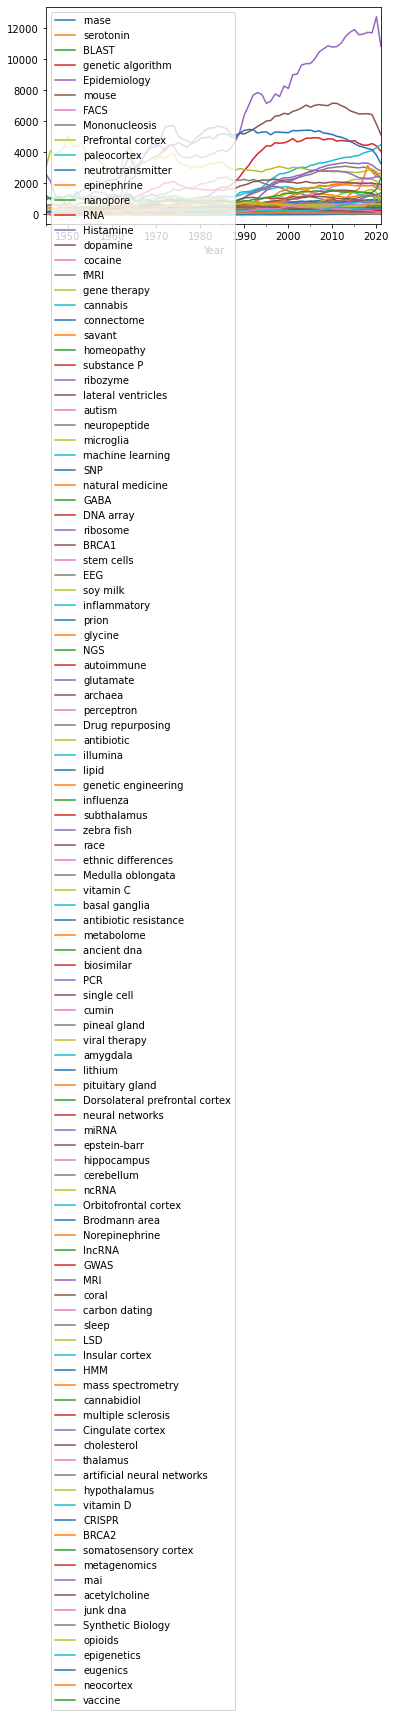

In [21]:
df.plot()

### Distrib of changes (pct_change) -> 3 classes

### 1st order difference makesi t easier to see big changes
* Note major OOM between topics

In [22]:
# df.diff().plot()

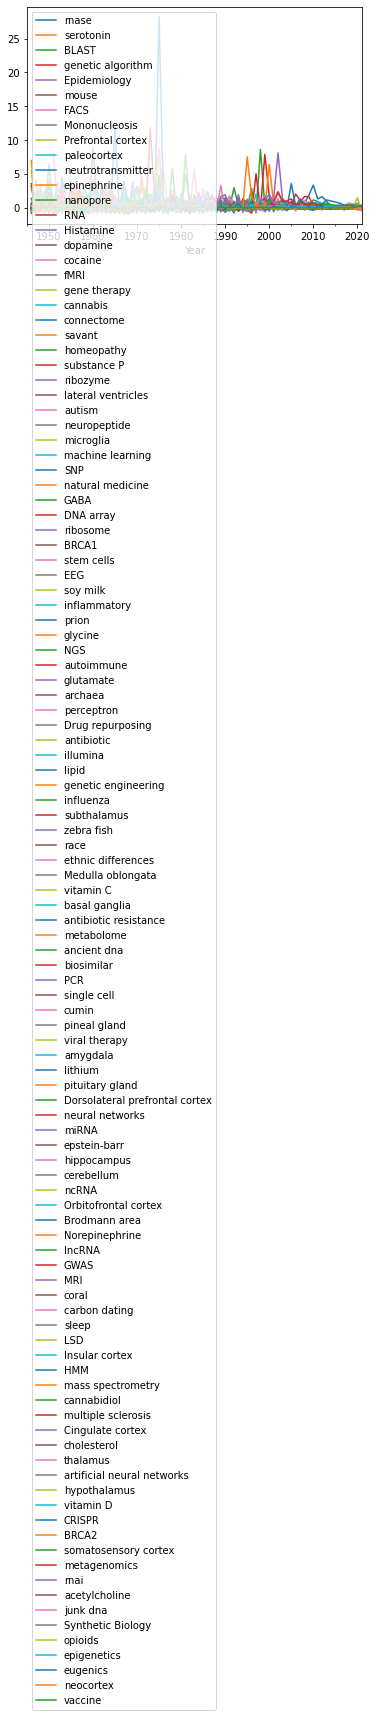

In [23]:
# df.apply(np.log1p).pct_change().plot();
df.pct_change().plot();

<AxesSubplot:xlabel='Year'>

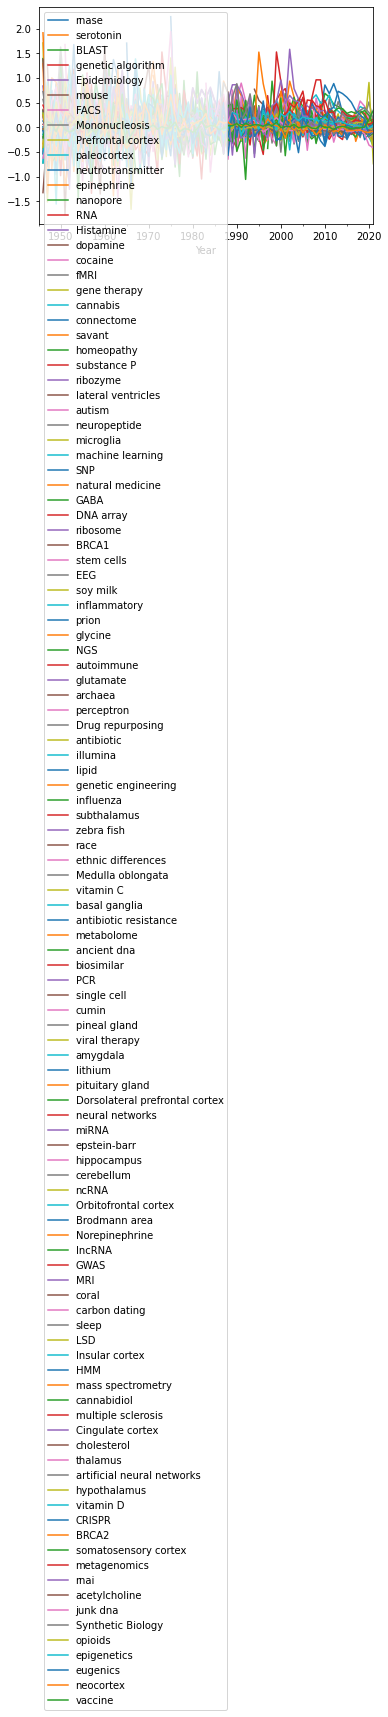

In [24]:
df.apply(np.log1p).diff().plot()

In [25]:
# df.apply(np.log1p).pct_change().clip(upper=2,lower=-2).plot()

To do corr properly, should do lag 1 or somesuch
* https://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas
* https://stackoverflow.com/questions/26083293/calculating-autocorrelation-of-pandas-dataframe-along-each-column

In [26]:
# df.corr().round(1)

In [27]:
def df_autocorr(df, lag=1, axis=0):
    """Compute full-sample column-wise autocorrelation for a DataFrame.
    https://stackoverflow.com/questions/26083293/calculating-autocorrelation-of-pandas-dataframe-along-each-column"""
    return df.apply(lambda col: col.autocorr(lag), axis=axis)

df_autocorr(df) ## this is series with itself...


rnase                0.971650
serotonin            0.982834
BLAST                0.981101
genetic algorithm    0.994244
Epidemiology         0.992874
                       ...   
opioids              0.976431
epigenetics          0.997931
eugenics             0.885752
neocortex            0.983646
vaccine              0.926032
Length: 113, dtype: float64

In [28]:
df.drop(columns=["prion"]).corrwith(df["prion"].shift(1))

rnase               -0.353498
serotonin            0.050022
BLAST                0.620833
genetic algorithm    0.774698
Epidemiology         0.866402
                       ...   
opioids              0.183144
epigenetics          0.536742
eugenics            -0.384902
neocortex            0.666089
vaccine              0.813419
Length: 112, dtype: float64

In [29]:
np.corrcoef(df['miRNA'][1:-1], df['miRNA'][2:])

array([[nan, nan],
       [nan, nan]])

### melt/reshape / wide to long
+- add ratio, per series
* Keep `df_mat_raw`, `df_raw` as time series cols of all series , raw values. May be overly noisy without filtering... 

In [30]:
df = df.melt(ignore_index=False).reset_index()
# df.dropna(axis=0,inplace=True) ## don't drop na rows yet - what about 0s in between!
df

,Year,variable,value
0,1945-01-01,rnase,14.624872
1,1946-01-01,rnase,14.833494
2,1947-01-01,rnase,6.149116
3,1948-01-01,rnase,14.132877
4,1949-01-01,rnase,4.775093
...,...,...,...
8696,2017-01-01,vaccine,1411.440403
8697,2018-01-01,vaccine,1402.250437
8698,2019-01-01,vaccine,1406.958057
8699,2020-01-01,vaccine,1641.144857


### pct change distrib (for target)
* Lots of noise on min end, due to cases of a target appearing once then going to 0? 
* We'll look at this later in the pipe after filtering for the targets

Target: percent change at: -, +- 0.03 (percent), +

In [31]:
# df["value"].dropna(axis=0).pct_change().describe() 
df.groupby("variable")["value"].pct_change().clip(upper=3).describe()

count    7631.000000
mean        0.117598
std         0.472226
min        -0.971698
25%        -0.046308
50%         0.009148
75%         0.125277
max         3.000000
Name: value, dtype: float64

<AxesSubplot:>

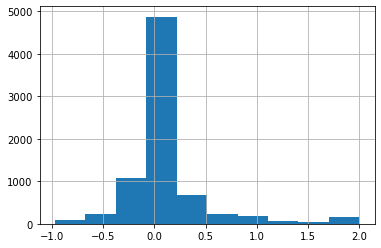

In [32]:
df.groupby("variable")["value"].pct_change().clip(upper=2).hist()

### keep TS context of targets and review ratio feats (for ts context)

In [33]:
df = df.merge(df_diff,on=["Year","variable"],how="left")
df = df.merge(df_ratio,on=["Year","variable"],how="left")

# 
df["pct_diff"] = df.groupby("variable")["value"].pct_change(1)

In [34]:
df_raw = df.copy()
df_raw

,Year,variable,value,research_review_diff,research_review_ratio,pct_diff
0,1945-01-01,rnase,14.624872,14.624872,1.000000,NaN
1,1946-01-01,rnase,14.833494,14.833494,1.000000,0.014265
2,1947-01-01,rnase,6.149116,6.149116,1.000000,-0.585457
3,1948-01-01,rnase,14.132877,14.132877,1.000000,1.298359
4,1949-01-01,rnase,4.775093,4.775093,1.000000,-0.662129
...,...,...,...,...,...,...
8696,2017-01-01,vaccine,1411.440403,1347.897958,0.954980,-0.010525
8697,2018-01-01,vaccine,1402.250437,1341.389647,0.956598,-0.006511
8698,2019-01-01,vaccine,1406.958057,1352.939840,0.961606,0.003357
8699,2020-01-01,vaccine,1641.144857,1585.519086,0.966106,0.166449


### Add lag features + missings + ratios
* Filter for rows which aren't surrounded by missing. 
###### Warning! May miss cases of very sparse/rare targets.. 

In [35]:
df["lag1"] = df.groupby("variable")["value"].shift(1) 
df["lag2"] = df.groupby("variable")["value"].shift(2) 
df["lag3"] = df.groupby("variable")["value"].shift(3) 
## future, leak
# df["future_lag1"] = df.groupby("variable")["value"].shift(-1)

## count current and past occurrences
# df["nans"] = df.drop(columns=["future_lag1"],axis=1).isna().sum(axis=1) 
## V1:
# df["non_nan"] = df.drop(columns=["future_lag1"],axis=1,errors="ignore").select_dtypes("number").notna().sum(axis=1)
df["non_nan"] = df[["value","lag1","lag2"]].notna().sum(axis=1) ## ALT? 

df

,Year,variable,value,research_review_diff,research_review_ratio,pct_diff,lag1,lag2,lag3,non_nan
0,1945-01-01,rnase,14.624872,14.624872,1.000000,NaN,NaN,NaN,NaN,1
1,1946-01-01,rnase,14.833494,14.833494,1.000000,0.014265,14.624872,NaN,NaN,2
2,1947-01-01,rnase,6.149116,6.149116,1.000000,-0.585457,14.833494,14.624872,NaN,3
3,1948-01-01,rnase,14.132877,14.132877,1.000000,1.298359,6.149116,14.833494,14.624872,3
4,1949-01-01,rnase,4.775093,4.775093,1.000000,-0.662129,14.132877,6.149116,14.833494,3
...,...,...,...,...,...,...,...,...,...,...
8696,2017-01-01,vaccine,1411.440403,1347.897958,0.954980,-0.010525,1426.453896,1467.252826,1467.608901,3
8697,2018-01-01,vaccine,1402.250437,1341.389647,0.956598,-0.006511,1411.440403,1426.453896,1467.252826,3
8698,2019-01-01,vaccine,1406.958057,1352.939840,0.961606,0.003357,1402.250437,1411.440403,1426.453896,3
8699,2020-01-01,vaccine,1641.144857,1585.519086,0.966106,0.166449,1406.958057,1402.250437,1411.440403,3


#### keep cases with at least K occurences > 0
* at least 3 cases over current + past 3 years? 

Taking `prion` as an example: first discussed in ~1959-60s 
* https://pubmed.ncbi.nlm.nih.gov/?term=prion&filter=years.1956-1966
* Do we want to keep first occurrence? 


* Some terms lack occurences - drop them? 

In [36]:
# df = df.loc[df["nans"]<3]
df = df.loc[(df["non_nan"]>2) & df["value"]>0]
print(df.variable.value_counts())
df

rnase                75
pineal gland         75
EEG                  75
inflammatory         75
glycine              75
                     ..
metagenomics         20
CRISPR               18
biosimilar           16
connectome           12
neutrotransmitter     4
Name: variable, Length: 113, dtype: int64


,Year,variable,value,research_review_diff,research_review_ratio,pct_diff,lag1,lag2,lag3,non_nan
2,1947-01-01,rnase,6.149116,6.149116,1.000000,-0.585457,14.833494,14.624872,NaN,3
3,1948-01-01,rnase,14.132877,14.132877,1.000000,1.298359,6.149116,14.833494,14.624872,3
4,1949-01-01,rnase,4.775093,4.775093,1.000000,-0.662129,14.132877,6.149116,14.833494,3
5,1950-01-01,rnase,5.828049,5.828049,1.000000,0.220510,4.775093,14.132877,6.149116,3
6,1951-01-01,rnase,9.631963,9.631963,1.000000,0.652691,5.828049,4.775093,14.132877,3
...,...,...,...,...,...,...,...,...,...,...
8696,2017-01-01,vaccine,1411.440403,1347.897958,0.954980,-0.010525,1426.453896,1467.252826,1467.608901,3
8697,2018-01-01,vaccine,1402.250437,1341.389647,0.956598,-0.006511,1411.440403,1426.453896,1467.252826,3
8698,2019-01-01,vaccine,1406.958057,1352.939840,0.961606,0.003357,1402.250437,1411.440403,1426.453896,3
8699,2020-01-01,vaccine,1641.144857,1585.519086,0.966106,0.166449,1406.958057,1402.250437,1411.440403,3


<AxesSubplot:xlabel='Year'>

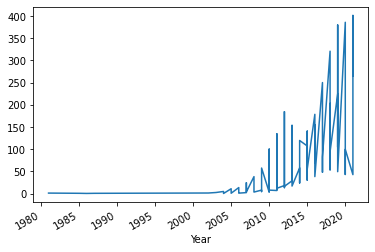

In [37]:
### https://stackoverflow.com/questions/13167391/filtering-grouped-dataframe-in-pandas
df.set_index("Year").groupby("variable").filter(lambda x: len(x) < 21)["value"].plot()

### pct_Change v2:

In [38]:
df.groupby("variable")["value"].pct_change()

2            NaN
3       1.298359
4      -0.662129
5       0.220510
6       0.652691
          ...   
8696   -0.010525
8697   -0.006511
8698    0.003357
8699    0.166449
8700    0.416559
Name: value, Length: 6877, dtype: float64

In [39]:
# df.groupby("variable")["value"].dropna(axis=0).pct_change().clip(upper=10).describe() # error
df.groupby("variable")["value"].pct_change().describe()

count    6764.000000
mean        0.124405
std         0.587410
min        -0.946303
25%        -0.047658
50%         0.017404
75%         0.127813
max        17.941830
Name: value, dtype: float64

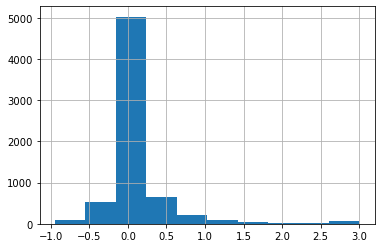

In [40]:
# df.groupby("variable")["value"].dropna(axis=0).pct_change().hist();
df.groupby("variable")["value"].pct_change().clip(upper=3).hist();

### Add differenced target 
###### Rename orig variable target col for consistency

In [41]:
df = df.drop(["non_nan"],axis=1,errors="ignore")
df["year_num"] = df["Year"].dt.year
df.fillna(0,inplace=True)

In [42]:
df["y_diff"] = df.groupby("variable")["value"].diff(1) ## 1st order diff, per group
df["y_pct_diff"] = df.groupby("variable")["value"].pct_change(1) ## % change diff, per group
df.fillna(0,inplace=True)

# df["diff_lag1"] = df.groupby("variable")["y_diff"].shift(1)
df["diff_lag5"] = df.groupby("variable")["y_diff"].shift(5)

# df["pct_diff_lag1"] = df.groupby("variable")["y_pct_diff"].shift(1)
df["pct_diff_lag6"] = df.groupby("variable")["y_pct_diff"].shift(6)
df.rename(columns={"value":"y_raw"},inplace=True)
df

,Year,variable,y_raw,research_review_diff,research_review_ratio,pct_diff,lag1,lag2,lag3,year_num,y_diff,y_pct_diff,diff_lag5,pct_diff_lag6
2,1947-01-01,rnase,6.149116,6.149116,1.000000,-0.585457,14.833494,14.624872,0.000000,1947,0.000000,0.000000,NaN,NaN
3,1948-01-01,rnase,14.132877,14.132877,1.000000,1.298359,6.149116,14.833494,14.624872,1948,7.983761,1.298359,NaN,NaN
4,1949-01-01,rnase,4.775093,4.775093,1.000000,-0.662129,14.132877,6.149116,14.833494,1949,-9.357784,-0.662129,NaN,NaN
5,1950-01-01,rnase,5.828049,5.828049,1.000000,0.220510,4.775093,14.132877,6.149116,1950,1.052956,0.220510,NaN,NaN
6,1951-01-01,rnase,9.631963,9.631963,1.000000,0.652691,5.828049,4.775093,14.132877,1951,3.803913,0.652691,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8696,2017-01-01,vaccine,1411.440403,1347.897958,0.954980,-0.010525,1426.453896,1467.252826,1467.608901,2017,-15.013493,-0.010525,-72.363273,0.003472
8697,2018-01-01,vaccine,1402.250437,1341.389647,0.956598,-0.006511,1411.440403,1426.453896,1467.252826,2018,-9.189966,-0.006511,5.087219,-0.048029
8698,2019-01-01,vaccine,1406.958057,1352.939840,0.961606,0.003357,1402.250437,1411.440403,1426.453896,2019,4.707620,0.003357,28.231237,0.003547
8699,2020-01-01,vaccine,1641.144857,1585.519086,0.966106,0.166449,1406.958057,1402.250437,1411.440403,2020,234.186800,0.166449,-0.356075,0.019614


In [43]:
# ### make features lag, to allow easily using as time series context
# df["research_review_ratio_lag1"] = df.groupby("variable")["research_review_ratio"].shift(1)
# df["research_review_diff_lag1"] = df.groupby("variable")["research_review_diff"].shift(1)

# df.drop(columns=["research_review_ratio","research_review_diff"],axis=1,errors="ignore",inplace=True)
# df

## drop partial and corona year


In [44]:
df = df.loc[df["year_num"]<2020]
print(df.shape[0])

6653


In [45]:
df_raw

,Year,variable,value,research_review_diff,research_review_ratio,pct_diff
0,1945-01-01,rnase,14.624872,14.624872,1.000000,NaN
1,1946-01-01,rnase,14.833494,14.833494,1.000000,0.014265
2,1947-01-01,rnase,6.149116,6.149116,1.000000,-0.585457
3,1948-01-01,rnase,14.132877,14.132877,1.000000,1.298359
4,1949-01-01,rnase,4.775093,4.775093,1.000000,-0.662129
...,...,...,...,...,...,...
8696,2017-01-01,vaccine,1411.440403,1347.897958,0.954980,-0.010525
8697,2018-01-01,vaccine,1402.250437,1341.389647,0.956598,-0.006511
8698,2019-01-01,vaccine,1406.958057,1352.939840,0.961606,0.003357
8699,2020-01-01,vaccine,1641.144857,1585.519086,0.966106,0.166449


In [46]:
df["y_pct_diff"].describe()

count    6653.000000
mean        0.127788
std         0.591001
min        -0.946303
25%        -0.042473
50%         0.017542
75%         0.129582
max        17.941830
Name: y_pct_diff, dtype: float64

<AxesSubplot:>

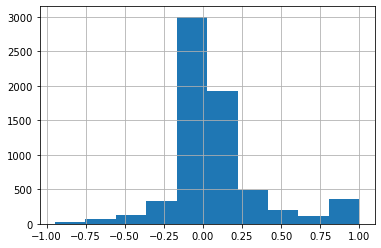

In [47]:
df["y_pct_diff"].clip(upper=1).hist()

* Trend

In [48]:
df[['y_raw','pct_diff','y_diff']].corrwith(df["year_num"])

y_raw       0.149140
pct_diff   -0.104580
y_diff     -0.016107
dtype: float64

In [49]:
df["y_pct_bins"] = pd.cut(df["y_pct_diff"],bins=[-20,-0.04,0.04,20])
df["y_pct_bins"]

/var/folders/hl/bb0z87yd5pzfcp81jc8662kr0000gn/T/ipykernel_11684/3869459519.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["y_pct_bins"] = pd.cut(df["y_pct_diff"],bins=[-20,-0.04,0.04,20])


2        (-0.04, 0.04]
3         (0.04, 20.0]
4       (-20.0, -0.04]
5         (0.04, 20.0]
6         (0.04, 20.0]
             ...      
8694     (-0.04, 0.04]
8695     (-0.04, 0.04]
8696     (-0.04, 0.04]
8697     (-0.04, 0.04]
8698     (-0.04, 0.04]
Name: y_pct_bins, Length: 6653, dtype: category
Categories (3, interval[float64, right]): [(-20.0, -0.04] < (-0.04, 0.04] < (0.04, 20.0]]

In [50]:
df["y_pct_bins"].value_counts()

(0.04, 20.0]      2840
(-0.04, 0.04]     2087
(-20.0, -0.04]    1726
Name: y_pct_bins, dtype: int64

### note that targets ranges over 2 OOM

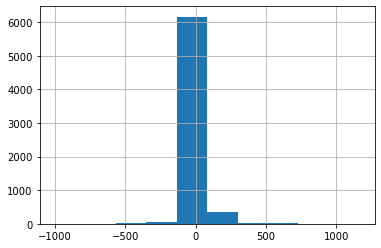

In [51]:
# df["y_diff"].describe()
df["y_diff"].hist();

In [52]:
df.groupby("variable")[["y_diff","y_raw"]].mean().round(1).sort_values(by=["y_raw"],ascending=False)

,y_diff,y_raw
variable,,
Epidemiology,143.3,5593.4
mouse,79.3,4492.2
lipid,42.7,4187.8
antibiotic,-13.5,3246.3
RNA,62.2,2500.7
...,...,...
Brodmann area,0.1,7.3
carbon dating,0.1,2.8
cumin,0.2,2.8


In [53]:
df[df["y_diff"]==0]

,Year,variable,y_raw,research_review_diff,research_review_ratio,pct_diff,lag1,lag2,lag3,year_num,y_diff,y_pct_diff,diff_lag5,pct_diff_lag6,y_pct_bins
2,1947-01-01,rnase,6.149116,6.149116,1.0,-0.585457,14.833494,14.624872,0.0,1947,0.0,0.0,NaN,NaN,"(-0.04, 0.04]"
82,1950-01-01,serotonin,2.331220,2.331220,1.0,0.464612,1.591698,8.479726,0.0,1950,0.0,0.0,NaN,NaN,"(-0.04, 0.04]"
156,1947-01-01,BLAST,26.133743,26.133743,1.0,-0.457906,48.208856,34.124701,0.0,1947,0.0,0.0,NaN,NaN,"(-0.04, 0.04]"
263,1977-01-01,genetic algorithm,1.906999,0.381400,0.2,0.620791,1.176586,1.203891,0.0,1977,0.0,0.0,NaN,NaN,"(-0.04, 0.04]"
310,1947-01-01,Epidemiology,1251.345119,1251.345119,1.0,-0.418211,2150.856634,2573.977478,0.0,1947,0.0,0.0,NaN,NaN,"(-0.04, 0.04]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8318,1947-01-01,opioids,181.398924,181.398924,1.0,1.329335,77.875844,116.998976,0.0,1947,0.0,0.0,NaN,NaN,"(-0.04, 0.04]"
8408,1960-01-01,epigenetics,0.891091,0.891091,1.0,-0.019800,0.909091,2.740502,0.0,1960,0.0,0.0,NaN,NaN,"(-0.04, 0.04]"
8472,1947-01-01,eugenics,81.475788,81.475788,1.0,-0.421822,140.918193,151.123678,0.0,1947,0.0,0.0,NaN,NaN,"(-0.04, 0.04]"
8550,1948-01-01,neocortex,1.413288,1.413288,1.0,-0.693552,4.611837,1.854187,0.0,1948,0.0,0.0,NaN,NaN,"(-0.04, 0.04]"


##### melt MESH data as possible target

In [54]:
df_mesh_flat = df_mesh.melt(ignore_index=False).reset_index()
df_mesh_flat["y_pct_diff"] = df_mesh_flat.groupby("variable")["value"].pct_change(1) ## % change diff, per group
df_mesh_flat.fillna(0,inplace=True)
df_mesh_flat["y_pct_bins"] = pd.cut(df_mesh_flat["y_pct_diff"],bins=[-20,-0.04,0.04,20])
df_mesh_flat["variable"] = df_mesh_flat["variable"].str.replace("[majr]","",regex=False)

df_mesh_flat = df_mesh_flat.merge(mesh_cat.drop(columns=["num"]),left_on="variable",right_on="mesh_name",how="left")
display(df_mesh_flat)

,Year,variable,value,y_pct_diff,y_pct_bins,mesh_id,mesh_name,mesh_tree_number
0,1945-01-01,Embryonic Structures,443.621118,0.000000,"(-0.04, 0.04]",D004628,Embryonic Structures,A16
1,1946-01-01,Embryonic Structures,684.194912,0.542296,"(0.04, 20.0]",D004628,Embryonic Structures,A16
2,1947-01-01,Embryonic Structures,694.850115,0.015573,"(-0.04, 0.04]",D004628,Embryonic Structures,A16
3,1948-01-01,Embryonic Structures,583.687833,-0.159980,"(-20.0, -0.04]",D004628,Embryonic Structures,A16
4,1949-01-01,Embryonic Structures,689.205106,0.180777,"(0.04, 20.0]",D004628,Embryonic Structures,A16
...,...,...,...,...,...,...,...,...
8696,2017-01-01,Cell Physiological Phenomena,3591.683000,-0.019350,"(-0.04, 0.04]",D002468,Cell Physiological Phenomena,G04
8697,2018-01-01,Cell Physiological Phenomena,3493.587695,-0.027312,"(-0.04, 0.04]",D002468,Cell Physiological Phenomena,G04
8698,2019-01-01,Cell Physiological Phenomena,3325.705005,-0.048055,"(-20.0, -0.04]",D002468,Cell Physiological Phenomena,G04
8699,2020-01-01,Cell Physiological Phenomena,2625.302588,-0.210603,"(-20.0, -0.04]",D002468,Cell Physiological Phenomena,G04


Cases of bad mesh name/url:

```['Pathological Conditions', ' Signs and Symptoms', 'Nucleic Acids',
       ' Nucleotides', ' and Nucleosides', 'Hormones',
       ' Hormone Substitutes', ' and Hormone Antagonists', 'Amino Acids',
       ' Peptides', ' and Proteins', 'Surgical Procedures', ' Operative',
       'Congenital', ' Hereditary',
       ' and Neonatal Diseases and Abnormalities',
       'Health Care Facilities', ' Manpower', ' and Services',
       'Technology', ' Industry', ' and Agriculture',
       'Health Care Quality', ' Access', ' and Evaluation']```

In [55]:
df_mesh_flat.loc[df_mesh_flat["mesh_name"].isna()].variable.unique()

array(['Pathological Conditions', ' Signs and Symptoms', 'Nucleic Acids',
       ' Nucleotides', ' and Nucleosides', 'Hormones',
       ' Hormone Substitutes', ' and Hormone Antagonists', 'Amino Acids',
       ' Peptides', ' and Proteins', 'Surgical Procedures', ' Operative',
       'Congenital', ' Hereditary',
       ' and Neonatal Diseases and Abnormalities',
       'Health Care Facilities', ' Manpower', ' and Services',
       'Technology', ' Industry', ' and Agriculture',
       'Health Care Quality', ' Access', ' and Evaluation'], dtype=object)

Mark/drop mesh cases with bad names / not joined ?
* What about amino acids, proteins... 

In [56]:
# df_mesh_flat.dropna(subset="mesh_name",axis=0,inplace=True)

In [57]:
df_mesh_flat.describe()

,value,y_pct_diff
count,8701.000000,8701.000000
mean,3132.395859,0.015055
std,3040.387924,0.348052
min,0.000000,-1.000000
25%,1088.426694,-0.032878
50%,2450.640926,0.000000
75%,4148.442729,0.036833
max,42575.411757,17.949364


In [58]:
df_mesh_flat2 = df_mesh_flat.dropna(subset=["mesh_name"],axis=0)
df_mesh_flat2.set_index("Year",inplace=True)
df_mesh_flat2 = df_mesh_flat2[['variable', 'value', 'y_pct_diff', 'y_pct_bins', 'mesh_tree_number']]
df_mesh_flat2

,variable,value,y_pct_diff,y_pct_bins,mesh_tree_number
Year,,,,,
1945-01-01,Embryonic Structures,443.621118,0.000000,"(-0.04, 0.04]",A16
1946-01-01,Embryonic Structures,684.194912,0.542296,"(0.04, 20.0]",A16
1947-01-01,Embryonic Structures,694.850115,0.015573,"(-0.04, 0.04]",A16
1948-01-01,Embryonic Structures,583.687833,-0.159980,"(-20.0, -0.04]",A16
1949-01-01,Embryonic Structures,689.205106,0.180777,"(0.04, 20.0]",A16
...,...,...,...,...,...
2017-01-01,Cell Physiological Phenomena,3591.683000,-0.019350,"(-0.04, 0.04]",G04
2018-01-01,Cell Physiological Phenomena,3493.587695,-0.027312,"(-0.04, 0.04]",G04
2019-01-01,Cell Physiological Phenomena,3325.705005,-0.048055,"(-20.0, -0.04]",G04


In [59]:
df_mesh_flat2["variable"].value_counts()

Embryonic Structures                     77
Digestive System                         77
Polycyclic Compounds                     77
Behavioral Disciplines and Activities    77
Persons                                  77
                                         ..
Respiratory System                       77
Neoplasms                                77
Animal Structures                        77
Complex Mixtures                         77
Cell Physiological Phenomena             77
Name: variable, Length: 88, dtype: int64

In [60]:
df_mesh_flat2["y_pct_diff"].describe().round(3)

count    6776.000
mean        0.017
std         0.380
min        -1.000
25%        -0.035
50%         0.000
75%         0.037
max        17.949
Name: y_pct_diff, dtype: float64

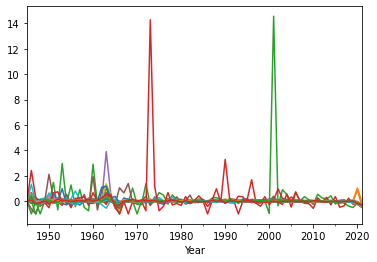

In [61]:
df_mesh_flat2.loc[df_mesh_flat2["mesh_tree_number"].str.startswith(("A","B","C"))].groupby("variable")["y_pct_diff"].plot();

# df_mesh_flat2.loc[df_mesh_flat2["mesh_tree_number"].str.startswith(("A","B","C"))][["variable","y_pct_diff"]].plot();

## merge+flat

In [62]:
df_mesh_flat = df_mesh_flat.merge(df_medline,on="Year")
df["year_num"] = df["Year"].dt.year
df_mesh_flat["total_value"] = df_mesh_flat["value"]*df_mesh_flat["Total Medline Cites"]
df_mesh_flat

/var/folders/hl/bb0z87yd5pzfcp81jc8662kr0000gn/T/ipykernel_11684/1969330042.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["year_num"] = df["Year"].dt.year


,Year,variable,value,y_pct_diff,y_pct_bins,mesh_id,mesh_name,mesh_tree_number,Total Medline Cites,% US Citations,total_value
0,1947-01-01,Embryonic Structures,694.850115,0.015573,"(-0.04, 0.04]",D004628,Embryonic Structures,A16,62869,NaN,4.368453e+07
1,1947-01-01,Digestive System,4928.516526,0.012590,"(-0.04, 0.04]",D004064,Digestive System,A03,62869,NaN,3.098509e+08
2,1947-01-01,Bacterial Structures,0.000000,-1.000000,"(-20.0, -0.04]",D056226,Bacterial Structures,A20,62869,NaN,0.000000e+00
3,1947-01-01,Information Science,1165.257494,-0.175267,"(-20.0, -0.04]",D007254,Information Science,L01,62869,NaN,7.325857e+07
4,1947-01-01,Human Activities,699.461952,-0.103958,"(-20.0, -0.04]",D006802,Human Activities,I03,62869,NaN,4.397447e+07
...,...,...,...,...,...,...,...,...,...,...,...
8357,2020-01-01,Genetic Phenomena,472.819057,-0.194656,"(-20.0, -0.04]",D055614,Genetic Phenomena,G05,362528,38.0,1.714101e+08
8358,2020-01-01,Viral Structures,3346.037833,-0.058154,"(-20.0, -0.04]",D056224,Viral Structures,A21,362528,38.0,1.213032e+09
8359,2020-01-01,Musculoskeletal System,3523.191147,-0.139178,"(-20.0, -0.04]",D009141,Musculoskeletal System,A02,362528,38.0,1.277255e+09
8360,2020-01-01,Plant Structures,51.995328,-0.097904,"(-20.0, -0.04]",D018514,Plant Structures,A18,362528,38.0,1.884976e+07


In [63]:
df_raw = df_raw.merge(df_medline,on="Year",how="left")
df_raw["total_value"] = df_raw["value"]*df_raw["Total Medline Cites"]
df_raw

,Year,variable,value,research_review_diff,research_review_ratio,pct_diff,Total Medline Cites,% US Citations,total_value
0,1945-01-01,rnase,14.624872,14.624872,1.000000,NaN,NaN,NaN,NaN
1,1946-01-01,rnase,14.833494,14.833494,1.000000,0.014265,NaN,NaN,NaN
2,1947-01-01,rnase,6.149116,6.149116,1.000000,-0.585457,62869.0,NaN,3.865888e+05
3,1948-01-01,rnase,14.132877,14.132877,1.000000,1.298359,68711.0,NaN,9.710841e+05
4,1949-01-01,rnase,4.775093,4.775093,1.000000,-0.662129,60931.0,NaN,2.909512e+05
...,...,...,...,...,...,...,...,...,...
8696,2017-01-01,vaccine,1411.440403,1347.897958,0.954980,-0.010525,848776.0,41.0,1.197997e+09
8697,2018-01-01,vaccine,1402.250437,1341.389647,0.956598,-0.006511,866977.0,40.0,1.215719e+09
8698,2019-01-01,vaccine,1406.958057,1352.939840,0.961606,0.003357,898145.0,39.0,1.263652e+09
8699,2020-01-01,vaccine,1641.144857,1585.519086,0.966106,0.166449,362528.0,38.0,5.949610e+08


## Export

In [64]:
# df.to_csv("trends_v2.csv.gz",index=False,compression="gzip")
# df_raw.to_csv("all_trends_matrix_v2.csv.gz",index=True,compression="gzip")
if SAVE_OUTPUT:
    df.to_csv("trends_v4.csv.gz",index=False,compression="gzip")
    df_raw.to_csv("trends_context_v4.csv.gz",index=False,compression="gzip")
    # matrix of major mesh trends:
    df_mesh.to_csv("mesh_matrix_v3.csv.gz",index=True,compression="gzip") 
    df_mesh_flat.to_csv("mesh_majr_v4.csv.gz",index=False,compression="gzip") 

### naive baseline
* boolean target - predict majority class, proba

In [65]:
dummy = (df["y_pct_diff"].dropna()>0)
dummy.mean() ## 0.59 

0.5707199759506989

In [66]:
roc_auc_score(y_true=(df["y_pct_diff"].dropna()>0).astype(int),y_score=[0.59]*len(dummy)) 

0.5